<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> HW #4: Approximate RL homework

<span style="color:red; font-size: 14pt;"> Дедлайн 19.11.2018 23:59 </span>

<span style="color:blue; font-size: 12pt">Valentin Malykh </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">val@maly.hk</span>


**Оформление дз**: 
- Выполненное задание требуется отправлять через <a href='https://goo.gl/forms/XPSIbwp7wPxB4SsI3'>форму </a>

- Выполненное дз прикрепляйте в формате файла ``<фамилия>_<группа>_task<номер>.ipynb``, например: ``ivanov_594_task4.ipynb`` 

**Вопросы**:
- Вопросы присылайте в канал в телеграмме ``[Fall 2018]ML Seminars``

--------
- **PS1**: Будьте внимательны при заполнении формы, когда отправляете ДЗ 


<h1 align="center">Практическое задание (100%)</h1>
Описание находится по ссылке: https://gist.github.com/madrugado/1262c3077bf7d8ac8166e4350f0f67e2

In [2]:
!pip install box2d-py
!pip install gym[Box_2D]

    100% |████████████████████████████████| 942kB 1.8MB/s ta 0:00:01
  gym 0.10.9 does not provide the extra 'box_2d'


In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

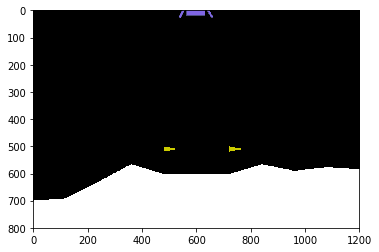

In [5]:
env = gym.make('LunarLander-v2')
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [6]:
n_actions, state_dim

(4, (8,))

In [24]:
env.observation_space

Box(8,)

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam, SGD

import random

env = gym.make('LunarLander-v2')
nb_actions = n_actions

Using TensorFlow backend.


In [26]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.compile(loss='mean_squared_error',  optimizer=Adam(lr=0.001, decay=2.25e-05))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                360       
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 164       
Total params: 2,164
Trainable params: 2,164
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
def forward_pass(state):
    input = np.zeros([1, 1, 8])
    input[0][0] = state
    return model.predict(input)[0]


def get_best_action(state):
    state_q_values = forward_pass(state)
    return np.argmax(state_q_values)


def get_targets(state, action, reward, next_state):
    current_state_q_values = forward_pass(state)
    next_state_q_values = forward_pass(next_state)
    max_q_next_state = np.max(next_state_q_values)
    targets = np.empty([1, nb_actions])

    for i in range(nb_actions):
        if i == action:
            targets[0][i] = reward + (gamma * max_q_next_state)
        else:
            targets[0][i] = current_state_q_values[i]
    return targets


def choose_action(state, epsilon):
    r = np.random.uniform()
    if r < epsilon:
        action = np.floor(np.random.randint(nb_actions))
    else:
        action = get_best_action(state)
    return int(action)


class Memory(object):
    def __init__(self, memory_size=10000, experience_size=1):
        self.experiences = np.empty([0, experience_size], dtype=object)
        self.max_memory_size = memory_size

    def add_experience(self, experience):
        self.experiences = np.insert(self.experiences, 0,
                                     experience, axis=0)
        if len(self.experiences) > self.max_memory_size:
            self.experiences = np.delete(self.experiences,
                                         self.max_memory_size, axis=0)

    def sample_experiences(self, mini_batch_size):
        if(mini_batch_size > len(self.experiences)):
            rep_needed = True
        else:
            rep_needed = False
        s = self.experiences[np.random.choice(
                self.experiences.shape[0],
                mini_batch_size, replace=rep_needed)]
        return s


def pack_experience(state, action, reward, new_state):
    experience = np.empty([0])
    experience = np.append(experience, state)
    experience = np.append(experience, [action])
    experience = np.append(experience, [reward])
    experience = np.append(experience, new_state)
    return experience


def unpack_experience(experience):
    state = experience[0:8]
    action = experience[8]
    reward = experience[9]
    new_state = experience[10:18]
    return state, action, reward, new_state


def learn_from_replay_memories(memory, batch_size):
    sample_batch = memory.sample_experiences(batch_size)
    for e in sample_batch:
        state, action, reward, new_state = unpack_experience(e)
        targets = get_targets(state, action, reward, new_state)
        x = np.empty([1, 1, 8])
        x[0][0] = state
        model.train_on_batch(x, targets)

In [29]:
mini_batch_size = 5
replay_memory_size = 25
gamma = 0.1
epsilon = 0.5
max_steps_per_epoch = 1000
max_epochs = 5000

memory = Memory(replay_memory_size, 18)
total_reward = np.zeros(max_epochs)


for epoch in range(max_epochs):
    state = env.reset()
    current_step = 0
    epoch_done = False
    while current_step < max_steps_per_epoch and not epoch_done:
        action = choose_action(state, epsilon)
        new_state, reward, epoch_done, info = env.step(action)
        total_reward[epoch] = total_reward[epoch] + reward
        experience = pack_experience(state, action, reward, new_state)
        memory.add_experience(experience)
        current_step = current_step + 1
        state = new_state

        learn_from_replay_memories(memory, mini_batch_size)

    if not epoch % 10 and epoch and gamma < 0.975:
        gamma = gamma * 1.0125
        print("New gamma = %0.2f" % gamma)
        
    if not epoch % 10 and epoch and epsilon > 0.01:
        epsilon = epsilon * 0.975
        print("New epsilon = %0.2f" % epsilon)

    print("Episode %i reward = %0.2f" % (epoch, total_reward[epoch]))
    if not epoch % 10 and epoch:
        print("---------------------------")
        print ("Last 10 episode avg = %0.2f" % np.mean(total_reward[epoch-10:epoch]))
        print( "---------------------------")

    if epoch and np.mean(total_reward[epoch-100:epoch]) > 250:
        break

print ("Max episode reward = %0.2f" % np.max(total_reward))

Episode 0 reward = -133.00
Episode 1 reward = -83.82
Episode 2 reward = 61.10
Episode 3 reward = 72.38
Episode 4 reward = -180.47
Episode 5 reward = -81.91
Episode 6 reward = -109.79
Episode 7 reward = -149.19
Episode 8 reward = -136.75
Episode 9 reward = -318.66
New gamma = 0.10
New epsilon = 0.49
Episode 10 reward = -259.59
---------------------------
Last 10 episode avg = -106.01
---------------------------
Episode 11 reward = -68.13
Episode 12 reward = -18.57
Episode 13 reward = 36.02
Episode 14 reward = -209.98
Episode 15 reward = -137.14
Episode 16 reward = 23.56
Episode 17 reward = -171.59
Episode 18 reward = -201.04
Episode 19 reward = -118.03
New gamma = 0.10
New epsilon = 0.48
Episode 20 reward = -21.86
---------------------------
Last 10 episode avg = -112.45
---------------------------
Episode 21 reward = 43.96
Episode 22 reward = -73.58
Episode 23 reward = -85.11
Episode 24 reward = -105.15
Episode 25 reward = -122.75
Episode 26 reward = 30.11
Episode 27 reward = -152.04
E

Episode 208 reward = 18.09
Episode 209 reward = -114.45
New gamma = 0.13
New epsilon = 0.29
Episode 210 reward = -322.86
---------------------------
Last 10 episode avg = -135.77
---------------------------
Episode 211 reward = -57.13
Episode 212 reward = -263.88
Episode 213 reward = -255.59
Episode 214 reward = -181.76
Episode 215 reward = -55.47
Episode 216 reward = -133.16
Episode 217 reward = -275.90
Episode 218 reward = -99.08
Episode 219 reward = -359.98
New gamma = 0.13
New epsilon = 0.29
Episode 220 reward = -405.39
---------------------------
Last 10 episode avg = -200.48
---------------------------
Episode 221 reward = -268.30
Episode 222 reward = -359.42
Episode 223 reward = -212.24
Episode 224 reward = -366.39
Episode 225 reward = -387.89
Episode 226 reward = -193.94
Episode 227 reward = -293.65
Episode 228 reward = -363.95
Episode 229 reward = -245.39
New gamma = 0.13
New epsilon = 0.28
Episode 230 reward = -326.69
---------------------------
Last 10 episode avg = -309.65


New gamma = 0.17
New epsilon = 0.18
Episode 410 reward = 47.67
---------------------------
Last 10 episode avg = -228.11
---------------------------
Episode 411 reward = 33.29
Episode 412 reward = 80.36
Episode 413 reward = -229.07
Episode 414 reward = -220.05
Episode 415 reward = -122.23
Episode 416 reward = -239.38
Episode 417 reward = -266.76
Episode 418 reward = -191.82
Episode 419 reward = -70.18
New gamma = 0.17
New epsilon = 0.17
Episode 420 reward = -277.15
---------------------------
Last 10 episode avg = -117.82
---------------------------
Episode 421 reward = -339.89
Episode 422 reward = -219.59
Episode 423 reward = 305.63
Episode 424 reward = -217.93
Episode 425 reward = -326.29
Episode 426 reward = -303.72
Episode 427 reward = -88.92
Episode 428 reward = -331.18
Episode 429 reward = -195.16
New gamma = 0.17
New epsilon = 0.17
Episode 430 reward = -365.74
---------------------------
Last 10 episode avg = -199.42
---------------------------
Episode 431 reward = 184.83
Episod

Episode 611 reward = 221.09
Episode 612 reward = -330.63
Episode 613 reward = 28.65
Episode 614 reward = -207.88
Episode 615 reward = -196.98
Episode 616 reward = -19.80
Episode 617 reward = -43.30
Episode 618 reward = -314.21
Episode 619 reward = -56.50
New gamma = 0.22
New epsilon = 0.10
Episode 620 reward = 218.43
---------------------------
Last 10 episode avg = -88.36
---------------------------
Episode 621 reward = -330.02
Episode 622 reward = 212.09
Episode 623 reward = -368.41
Episode 624 reward = -290.04
Episode 625 reward = -196.35
Episode 626 reward = -221.71
Episode 627 reward = -191.91
Episode 628 reward = -210.84
Episode 629 reward = 5.06
New gamma = 0.22
New epsilon = 0.10
Episode 630 reward = -265.72
---------------------------
Last 10 episode avg = -137.37
---------------------------
Episode 631 reward = -104.17
Episode 632 reward = -43.75
Episode 633 reward = -23.88
Episode 634 reward = -178.16
Episode 635 reward = -25.82
Episode 636 reward = 93.37
Episode 637 reward 

Episode 814 reward = 193.57
Episode 815 reward = 183.66
Episode 816 reward = 246.84
Episode 817 reward = 8.17
Episode 818 reward = -54.09
Episode 819 reward = -196.17
New gamma = 0.28
New epsilon = 0.06
Episode 820 reward = -145.28
---------------------------
Last 10 episode avg = 3.65
---------------------------
Episode 821 reward = -122.34
Episode 822 reward = -67.60
Episode 823 reward = -19.29
Episode 824 reward = -452.70
Episode 825 reward = -317.34
Episode 826 reward = -332.71
Episode 827 reward = -357.81
Episode 828 reward = -366.13
Episode 829 reward = -336.47
New gamma = 0.28
New epsilon = 0.06
Episode 830 reward = -367.57
---------------------------
Last 10 episode avg = -251.77
---------------------------
Episode 831 reward = -287.82
Episode 832 reward = -87.11
Episode 833 reward = -48.39
Episode 834 reward = -411.04
Episode 835 reward = -375.13
Episode 836 reward = -273.71
Episode 837 reward = -359.20
Episode 838 reward = -287.78
Episode 839 reward = -372.61
New gamma = 0.28

Episode 1015 reward = -57.38
Episode 1016 reward = 171.53
Episode 1017 reward = -316.06
Episode 1018 reward = -401.61
Episode 1019 reward = 135.60
New gamma = 0.36
New epsilon = 0.04
Episode 1020 reward = 169.62
---------------------------
Last 10 episode avg = 1.41
---------------------------
Episode 1021 reward = -52.78
Episode 1022 reward = 311.92
Episode 1023 reward = 226.57
Episode 1024 reward = 217.14
Episode 1025 reward = -430.32
Episode 1026 reward = -410.09
Episode 1027 reward = -363.24
Episode 1028 reward = -443.32
Episode 1029 reward = -358.72
New gamma = 0.36
New epsilon = 0.04
Episode 1030 reward = -345.58
---------------------------
Last 10 episode avg = -113.32
---------------------------
Episode 1031 reward = -449.99
Episode 1032 reward = -398.29
Episode 1033 reward = -416.01
Episode 1034 reward = -162.05
Episode 1035 reward = -403.16
Episode 1036 reward = -455.11
Episode 1037 reward = -381.23
Episode 1038 reward = -416.23
Episode 1039 reward = -416.44
New gamma = 0.36


Episode 1211 reward = -400.04
Episode 1212 reward = -360.71
Episode 1213 reward = -422.65
Episode 1214 reward = -408.38
Episode 1215 reward = -439.27
Episode 1216 reward = -382.71
Episode 1217 reward = -406.66
Episode 1218 reward = -391.92
Episode 1219 reward = -461.51
New gamma = 0.46
New epsilon = 0.02
Episode 1220 reward = -418.31
---------------------------
Last 10 episode avg = -405.32
---------------------------
Episode 1221 reward = -384.62
Episode 1222 reward = -380.63
Episode 1223 reward = -406.80
Episode 1224 reward = -350.20
Episode 1225 reward = -485.63
Episode 1226 reward = -439.87
Episode 1227 reward = -322.50
Episode 1228 reward = -438.71
Episode 1229 reward = -449.96
New gamma = 0.46
New epsilon = 0.02
Episode 1230 reward = -380.33
---------------------------
Last 10 episode avg = -407.72
---------------------------
Episode 1231 reward = -390.86
Episode 1232 reward = -369.56
Episode 1233 reward = 213.90
Episode 1234 reward = -290.99
Episode 1235 reward = -321.85
Episode

Episode 1411 reward = 234.09
Episode 1412 reward = -390.29
Episode 1413 reward = -422.65
Episode 1414 reward = -426.92
Episode 1415 reward = -399.30
Episode 1416 reward = -388.52
Episode 1417 reward = -433.86
Episode 1418 reward = -413.14
Episode 1419 reward = -405.60
New gamma = 0.58
New epsilon = 0.01
Episode 1420 reward = -427.05
---------------------------
Last 10 episode avg = -306.84
---------------------------
Episode 1421 reward = -196.00
Episode 1422 reward = 223.12
Episode 1423 reward = -10.15
Episode 1424 reward = -383.39
Episode 1425 reward = -392.91
Episode 1426 reward = 218.62
Episode 1427 reward = -182.05
Episode 1428 reward = 180.94
Episode 1429 reward = -159.43
New gamma = 0.59
New epsilon = 0.01
Episode 1430 reward = -129.68
---------------------------
Last 10 episode avg = -112.83
---------------------------
Episode 1431 reward = -321.29
Episode 1432 reward = -220.16
Episode 1433 reward = -324.03
Episode 1434 reward = -225.69
Episode 1435 reward = -247.50
Episode 143

Episode 1611 reward = -222.41
Episode 1612 reward = -173.00
Episode 1613 reward = -415.29
Episode 1614 reward = -208.52
Episode 1615 reward = 0.10
Episode 1616 reward = -4.61
Episode 1617 reward = 251.54
Episode 1618 reward = -419.00
Episode 1619 reward = -63.96
New gamma = 0.75
Episode 1620 reward = 236.89
---------------------------
Last 10 episode avg = -169.19
---------------------------
Episode 1621 reward = 20.73
Episode 1622 reward = 188.15
Episode 1623 reward = -46.24
Episode 1624 reward = -200.45
Episode 1625 reward = -242.60
Episode 1626 reward = -43.11
Episode 1627 reward = -224.25
Episode 1628 reward = -243.71
Episode 1629 reward = 8.01
New gamma = 0.76
Episode 1630 reward = -93.83
---------------------------
Last 10 episode avg = -54.66
---------------------------
Episode 1631 reward = -21.38
Episode 1632 reward = -412.69
Episode 1633 reward = -221.89
Episode 1634 reward = -241.14
Episode 1635 reward = -356.94
Episode 1636 reward = -152.78
Episode 1637 reward = -237.00
Epi

Episode 1821 reward = -4.01
Episode 1822 reward = 228.60
Episode 1823 reward = 240.86
Episode 1824 reward = 2.72
Episode 1825 reward = 255.28
Episode 1826 reward = 5.33
Episode 1827 reward = -250.04
Episode 1828 reward = -11.07
Episode 1829 reward = 245.71
New gamma = 0.97
Episode 1830 reward = 11.63
---------------------------
Last 10 episode avg = 56.37
---------------------------
Episode 1831 reward = 210.97
Episode 1832 reward = 300.67
Episode 1833 reward = 208.82
Episode 1834 reward = -271.60
Episode 1835 reward = 227.99
Episode 1836 reward = -20.72
Episode 1837 reward = 215.03
Episode 1838 reward = 245.96
Episode 1839 reward = 252.37
New gamma = 0.98
Episode 1840 reward = 223.62
---------------------------
Last 10 episode avg = 138.11
---------------------------
Episode 1841 reward = 38.38
Episode 1842 reward = -58.40
Episode 1843 reward = -90.30
Episode 1844 reward = -8.63
Episode 1845 reward = -145.00
Episode 1846 reward = -14.74
Episode 1847 reward = 204.64
Episode 1848 reward

Episode 2040 reward = 186.63
---------------------------
Last 10 episode avg = -13.72
---------------------------
Episode 2041 reward = -32.58
Episode 2042 reward = -9.19
Episode 2043 reward = -34.36
Episode 2044 reward = 94.15
Episode 2045 reward = 12.19
Episode 2046 reward = 119.26
Episode 2047 reward = -10.42
Episode 2048 reward = -211.29
Episode 2049 reward = -137.65
Episode 2050 reward = 185.38
---------------------------
Last 10 episode avg = -2.33
---------------------------
Episode 2051 reward = -63.76
Episode 2052 reward = 113.33
Episode 2053 reward = -52.32
Episode 2054 reward = -80.32
Episode 2055 reward = 105.59
Episode 2056 reward = 116.61
Episode 2057 reward = 117.75
Episode 2058 reward = 154.73
Episode 2059 reward = 104.82
Episode 2060 reward = -100.86
---------------------------
Last 10 episode avg = 70.18
---------------------------
Episode 2061 reward = 94.88
Episode 2062 reward = -22.02
Episode 2063 reward = 188.36
Episode 2064 reward = 79.92
Episode 2065 reward = -4

Episode 2258 reward = -135.65
Episode 2259 reward = 133.54
Episode 2260 reward = -21.45
---------------------------
Last 10 episode avg = -19.57
---------------------------
Episode 2261 reward = -88.25
Episode 2262 reward = 128.90
Episode 2263 reward = -38.55
Episode 2264 reward = -129.09
Episode 2265 reward = -61.67
Episode 2266 reward = 24.42
Episode 2267 reward = -70.15
Episode 2268 reward = -166.88
Episode 2269 reward = 189.00
Episode 2270 reward = 222.03
---------------------------
Last 10 episode avg = -23.37
---------------------------
Episode 2271 reward = -14.33
Episode 2272 reward = -159.87
Episode 2273 reward = 129.31
Episode 2274 reward = 113.34
Episode 2275 reward = -33.51
Episode 2276 reward = -60.84
Episode 2277 reward = -25.08
Episode 2278 reward = -52.48
Episode 2279 reward = -126.25
Episode 2280 reward = -11.58
---------------------------
Last 10 episode avg = -0.77
---------------------------
Episode 2281 reward = -33.77
Episode 2282 reward = 158.94
Episode 2283 rewa

Episode 2477 reward = -19.08
Episode 2478 reward = -74.73
Episode 2479 reward = -24.07
Episode 2480 reward = -35.39
---------------------------
Last 10 episode avg = -38.62
---------------------------
Episode 2481 reward = -28.15
Episode 2482 reward = -150.07
Episode 2483 reward = -60.50
Episode 2484 reward = -91.32
Episode 2485 reward = -169.80
Episode 2486 reward = -57.46
Episode 2487 reward = 195.27
Episode 2488 reward = 2.18
Episode 2489 reward = -98.70
Episode 2490 reward = -62.39
---------------------------
Last 10 episode avg = -49.39
---------------------------
Episode 2491 reward = -54.99
Episode 2492 reward = -44.73
Episode 2493 reward = -60.59
Episode 2494 reward = -68.17
Episode 2495 reward = -44.56
Episode 2496 reward = -78.18
Episode 2497 reward = -62.27
Episode 2498 reward = -62.84
Episode 2499 reward = 198.23
Episode 2500 reward = 118.89
---------------------------
Last 10 episode avg = -34.05
---------------------------
Episode 2501 reward = -45.38
Episode 2502 reward 

Episode 2696 reward = -38.62
Episode 2697 reward = -57.87
Episode 2698 reward = 216.83
Episode 2699 reward = 14.27
Episode 2700 reward = -74.65
---------------------------
Last 10 episode avg = -5.42
---------------------------
Episode 2701 reward = -83.71
Episode 2702 reward = 12.00
Episode 2703 reward = -75.49
Episode 2704 reward = -38.49
Episode 2705 reward = -50.31
Episode 2706 reward = -12.90
Episode 2707 reward = -50.55
Episode 2708 reward = -34.53
Episode 2709 reward = -81.44
Episode 2710 reward = 69.37
---------------------------
Last 10 episode avg = -49.01
---------------------------
Episode 2711 reward = -79.40
Episode 2712 reward = 130.82
Episode 2713 reward = -43.59
Episode 2714 reward = -49.38
Episode 2715 reward = -39.76
Episode 2716 reward = 164.60
Episode 2717 reward = -33.02
Episode 2718 reward = -78.54
Episode 2719 reward = -160.84
Episode 2720 reward = -60.64
---------------------------
Last 10 episode avg = -11.97
---------------------------
Episode 2721 reward = 7

Episode 2915 reward = -25.07
Episode 2916 reward = -41.07
Episode 2917 reward = -58.21
Episode 2918 reward = -22.17
Episode 2919 reward = 137.21
Episode 2920 reward = 172.22
---------------------------
Last 10 episode avg = -24.84
---------------------------
Episode 2921 reward = 131.93
Episode 2922 reward = -22.07
Episode 2923 reward = -50.16
Episode 2924 reward = -51.64
Episode 2925 reward = -36.30
Episode 2926 reward = 97.15
Episode 2927 reward = 205.46
Episode 2928 reward = 118.43
Episode 2929 reward = 228.81
Episode 2930 reward = -55.54
---------------------------
Last 10 episode avg = 79.38
---------------------------
Episode 2931 reward = -10.42
Episode 2932 reward = -58.87
Episode 2933 reward = -134.80
Episode 2934 reward = -44.70
Episode 2935 reward = -197.87
Episode 2936 reward = -115.08
Episode 2937 reward = -41.51
Episode 2938 reward = 107.00
Episode 2939 reward = -28.05
Episode 2940 reward = -42.30
---------------------------
Last 10 episode avg = -57.98
------------------

Episode 3135 reward = -32.96
Episode 3136 reward = 186.85
Episode 3137 reward = -35.06
Episode 3138 reward = 209.90
Episode 3139 reward = -29.12
Episode 3140 reward = -17.29
---------------------------
Last 10 episode avg = 29.15
---------------------------
Episode 3141 reward = -49.52
Episode 3142 reward = -34.92
Episode 3143 reward = -48.38
Episode 3144 reward = 144.60
Episode 3145 reward = 134.71
Episode 3146 reward = -56.26
Episode 3147 reward = 173.99
Episode 3148 reward = -133.92
Episode 3149 reward = -20.64
Episode 3150 reward = -51.43
---------------------------
Last 10 episode avg = 9.24
---------------------------
Episode 3151 reward = -39.78
Episode 3152 reward = 191.95
Episode 3153 reward = -49.34
Episode 3154 reward = -38.42
Episode 3155 reward = -35.81
Episode 3156 reward = -48.06
Episode 3157 reward = -27.81
Episode 3158 reward = -64.71
Episode 3159 reward = 109.15
Episode 3160 reward = -11.16
---------------------------
Last 10 episode avg = -5.43
----------------------

Episode 3355 reward = 123.49
Episode 3356 reward = -25.12
Episode 3357 reward = 231.30
Episode 3358 reward = -59.74
Episode 3359 reward = 193.85
Episode 3360 reward = -52.99
---------------------------
Last 10 episode avg = 74.50
---------------------------
Episode 3361 reward = 121.84
Episode 3362 reward = -15.19
Episode 3363 reward = -52.96
Episode 3364 reward = 208.46
Episode 3365 reward = -97.08
Episode 3366 reward = 118.45
Episode 3367 reward = -128.72
Episode 3368 reward = 24.74
Episode 3369 reward = -54.88
Episode 3370 reward = -64.48
---------------------------
Last 10 episode avg = 7.17
---------------------------
Episode 3371 reward = 113.91
Episode 3372 reward = 223.77
Episode 3373 reward = -33.96
Episode 3374 reward = 204.55
Episode 3375 reward = -60.17
Episode 3376 reward = 122.01
Episode 3377 reward = 221.05
Episode 3378 reward = -75.97
Episode 3379 reward = 74.82
Episode 3380 reward = 87.63
---------------------------
Last 10 episode avg = 72.55
-------------------------

Episode 3575 reward = 190.01
Episode 3576 reward = 206.22
Episode 3577 reward = 217.76
Episode 3578 reward = 31.36
Episode 3579 reward = 72.22
Episode 3580 reward = -41.83
---------------------------
Last 10 episode avg = 59.81
---------------------------
Episode 3581 reward = 64.81
Episode 3582 reward = -44.95
Episode 3583 reward = -45.66
Episode 3584 reward = 197.21
Episode 3585 reward = -4.22
Episode 3586 reward = -72.85
Episode 3587 reward = 252.75
Episode 3588 reward = -21.08
Episode 3589 reward = -34.60
Episode 3590 reward = 93.83
---------------------------
Last 10 episode avg = 24.96
---------------------------
Episode 3591 reward = -48.19
Episode 3592 reward = -45.55
Episode 3593 reward = 79.93
Episode 3594 reward = 27.49
Episode 3595 reward = 153.86
Episode 3596 reward = 182.49
Episode 3597 reward = -49.83
Episode 3598 reward = -65.78
Episode 3599 reward = -69.87
Episode 3600 reward = -148.72
---------------------------
Last 10 episode avg = 25.84
---------------------------


Episode 3795 reward = 210.70
Episode 3796 reward = -54.83
Episode 3797 reward = 163.16
Episode 3798 reward = 158.16
Episode 3799 reward = 243.44
Episode 3800 reward = -46.97
---------------------------
Last 10 episode avg = 71.90
---------------------------
Episode 3801 reward = -12.26
Episode 3802 reward = 153.11
Episode 3803 reward = -12.35
Episode 3804 reward = -32.88
Episode 3805 reward = -42.30
Episode 3806 reward = 247.76
Episode 3807 reward = -46.98
Episode 3808 reward = -13.29
Episode 3809 reward = -15.05
Episode 3810 reward = -1.22
---------------------------
Last 10 episode avg = 17.88
---------------------------
Episode 3811 reward = -19.13
Episode 3812 reward = 17.81
Episode 3813 reward = -31.35
Episode 3814 reward = 5.28
Episode 3815 reward = -24.18
Episode 3816 reward = 0.87
Episode 3817 reward = -30.28
Episode 3818 reward = -17.01
Episode 3819 reward = -33.90
Episode 3820 reward = -40.18
---------------------------
Last 10 episode avg = -13.31
---------------------------

Episode 4016 reward = -3.63
Episode 4017 reward = -32.54
Episode 4018 reward = -70.23
Episode 4019 reward = -23.29
Episode 4020 reward = 6.33
---------------------------
Last 10 episode avg = -14.59
---------------------------
Episode 4021 reward = -44.15
Episode 4022 reward = 102.46
Episode 4023 reward = -26.99
Episode 4024 reward = -8.62
Episode 4025 reward = -41.92
Episode 4026 reward = -36.70
Episode 4027 reward = -0.17
Episode 4028 reward = 16.61
Episode 4029 reward = 198.38
Episode 4030 reward = 266.13
---------------------------
Last 10 episode avg = 16.52
---------------------------
Episode 4031 reward = -9.40
Episode 4032 reward = -3.27
Episode 4033 reward = -153.14
Episode 4034 reward = -18.84
Episode 4035 reward = -69.91
Episode 4036 reward = -48.14
Episode 4037 reward = -41.80
Episode 4038 reward = -49.72
Episode 4039 reward = -87.06
Episode 4040 reward = -39.35
---------------------------
Last 10 episode avg = -21.52
---------------------------
Episode 4041 reward = 185.63

Episode 4237 reward = -97.35
Episode 4238 reward = 59.96
Episode 4239 reward = 121.80
Episode 4240 reward = -21.77
---------------------------
Last 10 episode avg = 36.66
---------------------------
Episode 4241 reward = -23.16
Episode 4242 reward = 0.11
Episode 4243 reward = -35.76
Episode 4244 reward = 34.69
Episode 4245 reward = -51.70
Episode 4246 reward = -43.04
Episode 4247 reward = -61.21
Episode 4248 reward = -38.09
Episode 4249 reward = -40.07
Episode 4250 reward = 138.25
---------------------------
Last 10 episode avg = -28.00
---------------------------
Episode 4251 reward = -15.13
Episode 4252 reward = -11.05
Episode 4253 reward = -46.51
Episode 4254 reward = -23.52
Episode 4255 reward = -37.39
Episode 4256 reward = 210.18
Episode 4257 reward = 14.27
Episode 4258 reward = -93.10
Episode 4259 reward = -13.86
Episode 4260 reward = -21.36
---------------------------
Last 10 episode avg = 12.21
---------------------------
Episode 4261 reward = -61.84
Episode 4262 reward = -19.4

Episode 4459 reward = -16.32
Episode 4460 reward = -44.76
---------------------------
Last 10 episode avg = 14.48
---------------------------
Episode 4461 reward = -27.47
Episode 4462 reward = 165.28
Episode 4463 reward = -36.03
Episode 4464 reward = 52.77
Episode 4465 reward = -5.29
Episode 4466 reward = 248.20
Episode 4467 reward = -29.07
Episode 4468 reward = -55.85
Episode 4469 reward = -19.95
Episode 4470 reward = 21.11
---------------------------
Last 10 episode avg = 24.78
---------------------------
Episode 4471 reward = -22.83
Episode 4472 reward = -54.14
Episode 4473 reward = -12.86
Episode 4474 reward = -42.87
Episode 4475 reward = -28.61
Episode 4476 reward = -32.87
Episode 4477 reward = -71.81
Episode 4478 reward = -53.69
Episode 4479 reward = -17.54
Episode 4480 reward = 191.04
---------------------------
Last 10 episode avg = -31.61
---------------------------
Episode 4481 reward = -55.94
Episode 4482 reward = -42.58
Episode 4483 reward = -69.39
Episode 4484 reward = 10.

Episode 4680 reward = -35.70
---------------------------
Last 10 episode avg = 6.33
---------------------------
Episode 4681 reward = -39.95
Episode 4682 reward = -49.06
Episode 4683 reward = 14.96
Episode 4684 reward = 111.34
Episode 4685 reward = 189.08
Episode 4686 reward = -66.05
Episode 4687 reward = 270.26
Episode 4688 reward = 15.39
Episode 4689 reward = -33.69
Episode 4690 reward = -34.31
---------------------------
Last 10 episode avg = 37.66
---------------------------
Episode 4691 reward = -54.32
Episode 4692 reward = -50.69
Episode 4693 reward = 43.35
Episode 4694 reward = 142.17
Episode 4695 reward = -26.44
Episode 4696 reward = 242.17
Episode 4697 reward = -43.51
Episode 4698 reward = 100.95
Episode 4699 reward = -65.68
Episode 4700 reward = 67.32
---------------------------
Last 10 episode avg = 25.37
---------------------------
Episode 4701 reward = -41.43
Episode 4702 reward = -35.98
Episode 4703 reward = -36.74
Episode 4704 reward = -36.18
Episode 4705 reward = -5.60


Episode 4901 reward = 143.78
Episode 4902 reward = 191.62
Episode 4903 reward = -15.24
Episode 4904 reward = -58.74
Episode 4905 reward = -3.09
Episode 4906 reward = 204.22
Episode 4907 reward = -9.10
Episode 4908 reward = 1.91
Episode 4909 reward = -26.43
Episode 4910 reward = -49.11
---------------------------
Last 10 episode avg = 40.80
---------------------------
Episode 4911 reward = -56.01
Episode 4912 reward = -44.06
Episode 4913 reward = -34.38
Episode 4914 reward = -71.50
Episode 4915 reward = -31.02
Episode 4916 reward = -28.32
Episode 4917 reward = 188.70
Episode 4918 reward = 232.71
Episode 4919 reward = -24.78
Episode 4920 reward = 142.54
---------------------------
Last 10 episode avg = 8.22
---------------------------
Episode 4921 reward = -54.98
Episode 4922 reward = -21.95
Episode 4923 reward = -39.10
Episode 4924 reward = 4.75
Episode 4925 reward = 126.39
Episode 4926 reward = -38.86
Episode 4927 reward = 9.40
Episode 4928 reward = 8.97
Episode 4929 reward = -33.53
Ep

In [51]:
mini_batch_size = 5
replay_memory_size = 25
gamma = 0.9
epsilon = 0.1
max_steps_per_epoch = 1000
max_epochs = 2000

memory = Memory(replay_memory_size, 18)
total_reward = np.zeros(max_epochs)


for epoch in range(max_epochs):
    state = env.reset()
    current_step = 0
    epoch_done = False
    while current_step < max_steps_per_epoch and not epoch_done:
        action = choose_action(state, epsilon)
        new_state, reward, epoch_done, info = env.step(action)
        total_reward[epoch] = total_reward[epoch] + reward
        experience = pack_experience(state, action, reward, new_state)
        memory.add_experience(experience)

        current_step = current_step + 1
        state = new_state

        learn_from_replay_memories(memory, mini_batch_size)

    if not epoch % 10 and epoch and gamma < 0.975:
        gamma = gamma * 1.0125
        print("New gamma = %0.2f" % gamma)
        
    if not epoch % 10 and epoch and epsilon > 0.01:
        epsilon = epsilon * 0.975
        print("New epsilon = %0.2f" % epsilon)

    print("Episode %i reward = %0.2f" % (epoch, total_reward[epoch]))
    if not epoch % 10 and epoch:
        print("---------------------------")
        print ("Last 10 episode avg = %0.2f" % np.mean(total_reward[epoch-10:epoch]))
        print( "---------------------------")

    if epoch and np.mean(total_reward[epoch-100:epoch]) > 250:
        break

print ("Max episode reward = %0.2f" % np.max(total_reward))

Episode 0 reward = -2.25
Episode 1 reward = -37.13


/Users/ya-philya/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 2 reward = -37.27
Episode 3 reward = 177.39
Episode 4 reward = 42.09
Episode 5 reward = 151.59
Episode 6 reward = -187.74
Episode 7 reward = 103.72
Episode 8 reward = 150.55
Episode 9 reward = 205.74
New gamma = 0.91
New epsilon = 0.10
Episode 10 reward = 176.56
---------------------------
Last 10 episode avg = 56.67
---------------------------
Episode 11 reward = 28.05
Episode 12 reward = 113.02
Episode 13 reward = -71.25
Episode 14 reward = -41.62
Episode 15 reward = -46.90
Episode 16 reward = -3.41
Episode 17 reward = -19.30
Episode 18 reward = 193.18
Episode 19 reward = -9.76
New gamma = 0.92
New epsilon = 0.10
Episode 20 reward = 246.44
---------------------------
Last 10 episode avg = 31.86
---------------------------
Episode 21 reward = -50.93
Episode 22 reward = 226.39
Episode 23 reward = 140.69
Episode 24 reward = 190.87
Episode 25 reward = 7.27
Episode 26 reward = 33.32
Episode 27 reward = 153.76
Episode 28 reward = 169.39
Episode 29 reward = 96.93
New gamma = 0.93
Ne

Episode 219 reward = -33.51
New epsilon = 0.06
Episode 220 reward = -39.10
---------------------------
Last 10 episode avg = 0.03
---------------------------
Episode 221 reward = -29.56
Episode 222 reward = -25.56
Episode 223 reward = 42.20
Episode 224 reward = -54.59
Episode 225 reward = 175.07
Episode 226 reward = -50.40
Episode 227 reward = 247.72
Episode 228 reward = 290.07
Episode 229 reward = -130.11
New epsilon = 0.06
Episode 230 reward = -14.40
---------------------------
Last 10 episode avg = 42.57
---------------------------
Episode 231 reward = 103.36
Episode 232 reward = 4.12
Episode 233 reward = -31.84
Episode 234 reward = 176.30
Episode 235 reward = 242.28
Episode 236 reward = 174.65
Episode 237 reward = 306.30
Episode 238 reward = 11.63
Episode 239 reward = 100.82
New epsilon = 0.05
Episode 240 reward = 221.73
---------------------------
Last 10 episode avg = 107.32
---------------------------
Episode 241 reward = -68.74
Episode 242 reward = 273.06
Episode 243 reward = 2

Episode 433 reward = 205.72
Episode 434 reward = 27.53
Episode 435 reward = -12.91
Episode 436 reward = 62.32
Episode 437 reward = -1.75
Episode 438 reward = -39.77
Episode 439 reward = 139.76
New epsilon = 0.03
Episode 440 reward = 109.46
---------------------------
Last 10 episode avg = 62.16
---------------------------
Episode 441 reward = 276.53
Episode 442 reward = 155.25
Episode 443 reward = -22.09
Episode 444 reward = 20.93
Episode 445 reward = -64.55
Episode 446 reward = -27.94
Episode 447 reward = -22.99
Episode 448 reward = -55.97
Episode 449 reward = -12.38
New epsilon = 0.03
Episode 450 reward = 218.86
---------------------------
Last 10 episode avg = 35.62
---------------------------
Episode 451 reward = 263.82
Episode 452 reward = 135.81
Episode 453 reward = -77.36
Episode 454 reward = 138.62
Episode 455 reward = -52.57
Episode 456 reward = 167.91
Episode 457 reward = -3.27
Episode 458 reward = -63.94
Episode 459 reward = 68.91
New epsilon = 0.03
Episode 460 reward = -39.

Episode 651 reward = 187.83
Episode 652 reward = 39.04
Episode 653 reward = -31.95
Episode 654 reward = 8.05
Episode 655 reward = 69.64
Episode 656 reward = 182.84
Episode 657 reward = 139.83
Episode 658 reward = -18.22
Episode 659 reward = -45.29
New epsilon = 0.02
Episode 660 reward = 42.72
---------------------------
Last 10 episode avg = 44.69
---------------------------
Episode 661 reward = -150.88
Episode 662 reward = 186.98
Episode 663 reward = 146.74
Episode 664 reward = 177.58
Episode 665 reward = 180.94
Episode 666 reward = -11.92
Episode 667 reward = -123.06
Episode 668 reward = 173.95
Episode 669 reward = 200.48
New epsilon = 0.02
Episode 670 reward = 133.15
---------------------------
Last 10 episode avg = 82.35
---------------------------
Episode 671 reward = -155.89
Episode 672 reward = 65.07
Episode 673 reward = 83.69
Episode 674 reward = 237.93
Episode 675 reward = 112.10
Episode 676 reward = 136.00
Episode 677 reward = 54.31
Episode 678 reward = -16.56
Episode 679 rew

Episode 868 reward = -54.66
Episode 869 reward = 146.83
New epsilon = 0.01
Episode 870 reward = 168.08
---------------------------
Last 10 episode avg = 72.04
---------------------------
Episode 871 reward = 144.74
Episode 872 reward = -1.02
Episode 873 reward = 213.65
Episode 874 reward = -14.15
Episode 875 reward = 113.66
Episode 876 reward = 164.71
Episode 877 reward = -38.55
Episode 878 reward = 133.95
Episode 879 reward = 100.24
New epsilon = 0.01
Episode 880 reward = 140.80
---------------------------
Last 10 episode avg = 98.53
---------------------------
Episode 881 reward = 14.56
Episode 882 reward = -39.80
Episode 883 reward = -65.44
Episode 884 reward = -107.35
Episode 885 reward = -43.80
Episode 886 reward = -30.66
Episode 887 reward = 114.77
Episode 888 reward = 298.41
Episode 889 reward = 137.77
New epsilon = 0.01
Episode 890 reward = -26.83
---------------------------
Last 10 episode avg = 41.93
---------------------------
Episode 891 reward = -35.10
Episode 892 reward =

Episode 1090 reward = 208.75
---------------------------
Last 10 episode avg = 138.48
---------------------------
Episode 1091 reward = 139.34
Episode 1092 reward = 173.23
Episode 1093 reward = 103.19
Episode 1094 reward = 132.35
Episode 1095 reward = 73.92
Episode 1096 reward = 153.35
Episode 1097 reward = 220.53
Episode 1098 reward = 122.23
Episode 1099 reward = 209.31
Episode 1100 reward = -148.58
---------------------------
Last 10 episode avg = 153.62
---------------------------
Episode 1101 reward = 161.47
Episode 1102 reward = 144.71
Episode 1103 reward = 127.00
Episode 1104 reward = 219.25
Episode 1105 reward = 169.36
Episode 1106 reward = 122.13
Episode 1107 reward = 137.90
Episode 1108 reward = 137.17
Episode 1109 reward = 87.73
Episode 1110 reward = -80.15
---------------------------
Last 10 episode avg = 115.81
---------------------------
Episode 1111 reward = 170.13
Episode 1112 reward = 145.74
Episode 1113 reward = 151.67
Episode 1114 reward = 9.62
Episode 1115 reward = 1

Episode 1310 reward = 157.35
---------------------------
Last 10 episode avg = 139.73
---------------------------
Episode 1311 reward = 37.95
Episode 1312 reward = 68.30
Episode 1313 reward = 168.10
Episode 1314 reward = -64.60
Episode 1315 reward = 132.57
Episode 1316 reward = 132.45
Episode 1317 reward = 74.08
Episode 1318 reward = -46.46
Episode 1319 reward = 162.95
Episode 1320 reward = 180.41
---------------------------
Last 10 episode avg = 82.27
---------------------------
Episode 1321 reward = 149.62
Episode 1322 reward = 134.74
Episode 1323 reward = 145.03
Episode 1324 reward = 116.87
Episode 1325 reward = 183.68
Episode 1326 reward = 141.70
Episode 1327 reward = -106.16
Episode 1328 reward = 136.45
Episode 1329 reward = 134.59
Episode 1330 reward = -12.32
---------------------------
Last 10 episode avg = 121.69
---------------------------
Episode 1331 reward = 125.25
Episode 1332 reward = -36.51
Episode 1333 reward = -22.77
Episode 1334 reward = 173.74
Episode 1335 reward = 1

Episode 1529 reward = 230.90
Episode 1530 reward = 225.01
---------------------------
Last 10 episode avg = 139.87
---------------------------
Episode 1531 reward = -94.22
Episode 1532 reward = -103.41
Episode 1533 reward = 132.57
Episode 1534 reward = -59.18
Episode 1535 reward = 147.10
Episode 1536 reward = 140.42
Episode 1537 reward = -65.69
Episode 1538 reward = 156.28
Episode 1539 reward = 104.21
Episode 1540 reward = 141.54
---------------------------
Last 10 episode avg = 58.31
---------------------------
Episode 1541 reward = 186.74
Episode 1542 reward = -36.05
Episode 1543 reward = 163.35
Episode 1544 reward = 135.79
Episode 1545 reward = 164.61
Episode 1546 reward = 146.93
Episode 1547 reward = 83.70
Episode 1548 reward = -84.59
Episode 1549 reward = -46.63
Episode 1550 reward = 19.71
---------------------------
Last 10 episode avg = 85.54
---------------------------
Episode 1551 reward = 60.22
Episode 1552 reward = -93.87
Episode 1553 reward = 111.40
Episode 1554 reward = 13

Episode 1749 reward = 23.67
Episode 1750 reward = 126.25
---------------------------
Last 10 episode avg = 119.23
---------------------------
Episode 1751 reward = -34.52
Episode 1752 reward = 153.10
Episode 1753 reward = 69.30
Episode 1754 reward = 128.68
Episode 1755 reward = 52.99
Episode 1756 reward = 152.17
Episode 1757 reward = 153.21
Episode 1758 reward = 97.02
Episode 1759 reward = 38.44
Episode 1760 reward = 133.19
---------------------------
Last 10 episode avg = 93.66
---------------------------
Episode 1761 reward = 213.33
Episode 1762 reward = 144.89
Episode 1763 reward = 144.37
Episode 1764 reward = 123.68
Episode 1765 reward = 28.29
Episode 1766 reward = 246.73
Episode 1767 reward = 44.60
Episode 1768 reward = 136.32
Episode 1769 reward = 191.83
Episode 1770 reward = -4.67
---------------------------
Last 10 episode avg = 140.72
---------------------------
Episode 1771 reward = 121.83
Episode 1772 reward = 117.28
Episode 1773 reward = 162.28
Episode 1774 reward = 152.24


Episode 1969 reward = 94.46
Episode 1970 reward = 125.26
---------------------------
Last 10 episode avg = 71.83
---------------------------
Episode 1971 reward = -86.78
Episode 1972 reward = 159.31
Episode 1973 reward = 118.55
Episode 1974 reward = 88.46
Episode 1975 reward = 170.55
Episode 1976 reward = 138.09
Episode 1977 reward = 79.16
Episode 1978 reward = 143.11
Episode 1979 reward = 119.44
Episode 1980 reward = 144.94
---------------------------
Last 10 episode avg = 105.51
---------------------------
Episode 1981 reward = 119.47
Episode 1982 reward = -41.76
Episode 1983 reward = 192.39
Episode 1984 reward = -90.62
Episode 1985 reward = 166.79
Episode 1986 reward = 138.29
Episode 1987 reward = -117.15
Episode 1988 reward = 134.68
Episode 1989 reward = 134.89
Episode 1990 reward = 156.34
---------------------------
Last 10 episode avg = 78.19
---------------------------
Episode 1991 reward = -153.99
Episode 1992 reward = 184.97
Episode 1993 reward = 153.98
Episode 1994 reward = 8

In [55]:
total = 0
for g in range(10):
    state = env.reset()
    game_done = False
    total_rew = 0
    while not game_done:
        state, reward, game_done, info = env.step(get_best_action(state))
        total_rew += reward
        total += reward
    print('Game {}, reward {}, state {}'.format(g, total_rew, state[-2:]))
print('Mean {}'.format(total / 10))

Game 0, reward -92.85723617166775, state [1. 1.]
Game 1, reward 145.221182917622, state [1. 1.]
Game 2, reward 136.7218331570636, state [1. 1.]
Game 3, reward 32.80375668924748, state [1. 1.]
Game 4, reward 142.8122451451274, state [1. 1.]
Game 5, reward 120.87007230450243, state [0. 1.]
Game 6, reward 129.60844563287904, state [1. 1.]
Game 7, reward 148.74873210818535, state [1. 1.]
Game 8, reward 145.97603792747393, state [1. 1.]
Game 9, reward 151.10791689669483, state [1. 1.]
Mean 106.10129866071318


{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}